In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
import PIL

2022-03-18 22:13:55.285347: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-18 22:13:55.285378: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# function to verify the image is supported by PIL lib
def verifyImageAndCopy(imagePath , copyTo):
    try:
        img = PIL.Image.open(imagePath)
        shutil.copy(imagePath , copyTo)
    except PIL.UnidentifiedImageError:
        print("skipping")

In [3]:
# all shapes - Octagon , Triangle , Nonagon , Star , Hexagon , Square , Heptagon , Pentagon , Circle
shapes_list = ["Octagon" , "Triangle" , "Nonagon" , "Star" , "Hexagon" , "Square" , "Heptagon" , "Pentagon" , "Circle"]


In [4]:
# generating folders
for i in shapes_list:
    os.system(f"rm -rf data/train/{i}")
    os.system(f"rm -rf data/valid/{i}")
    os.system(f"rm -rf data/test/{i}")
    os.makedirs(f'data/train/{i}')
    os.makedirs(f'data/valid/{i}')
    os.makedirs(f'data/test/{i}')

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import uuid

# function to generate 2 more agumented image
def generate_augmented_images(image_path , saveTo , count = 2):
    gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
    channel_shift_range=10., brightness_range=[0.2,1.2] , horizontal_flip=True)
    
    # converting image to 500 , 500 pixel to make augmentation work
    im = PIL.Image.open(image_path)
    basewidth = 500
    wpercent = (basewidth/float(im.size[0]))
    hsize = int((float(im.size[1])*float(wpercent)))
    im = im.resize((basewidth,hsize), PIL.Image.ANTIALIAS)
    
    image = np.expand_dims(im,0)
    
    aug_iter = gen.flow(image, save_to_dir=saveTo, save_prefix=f'aug-image-{uuid.uuid4()}-', save_format='jpeg')
    
    tempCount = 1
    for i in aug_iter:
        if(tempCount >= count):
            break
        tempCount = tempCount + 1

In [6]:
from IPython.display import clear_output

dataset_path = "predatasets/Dataset_5/output/"

# copying all shapes into respective train test and valid folders
for shape in shapes_list:
    print(f"\non {shape}")
    
    allImages = []
    
    for i in glob.glob(f"{dataset_path}/{shape}*"):
        allImages.append(i)
    
    # shuffle images for better training
    random.shuffle(allImages)
        
    # keeping only 1 tenth of images of better runtime
    allImages = allImages[:len(allImages) // 10]
    
    
    # using 60 % data as train
    # using 20 % data as valid
    # using 20 % data as test
    
    len_allImages = len(allImages)
    
    train_len = int(60 / 100 * len_allImages)
    valid_len = int(20 / 100 * len_allImages)
    test_len = int(20 / 100 * len_allImages)
    
    # copy train
    for count , i in enumerate(allImages[:train_len]):
        print(f"\r{count} / {train_len}" , end="")
        generate_augmented_images(i , f'data/train/{shape}')
        verifyImageAndCopy(i , f'data/train/{shape}')
        
    # copy valid
    for i in allImages[train_len : train_len + valid_len]:
        verifyImageAndCopy(i , f'data/valid/{shape}')
        
    # copy test
    for i in allImages[train_len + valid_len : train_len + valid_len + test_len]:
        verifyImageAndCopy(i , f'data/test/{shape}')


on Octagon
599 / 600
on Triangle
599 / 600
on Nonagon
599 / 600
on Star
599 / 600
on Hexagon
599 / 600
on Square
599 / 600
on Heptagon
599 / 600
on Pentagon
599 / 600
on Circle
599 / 600

In [7]:
train_path = 'data/train'
valid_path = 'data/valid'
test_path = 'data/test'

In [8]:

# converting data into batches
# target size = height and width of the images we want images to be resized to [for reduced complexity]
# classes = all output classes
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=shapes_list, batch_size=25)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=shapes_list, batch_size=25)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=shapes_list, batch_size=25, shuffle=False)

Found 16199 images belonging to 9 classes.
Found 1800 images belonging to 9 classes.
Found 1800 images belonging to 9 classes.


In [9]:
# get first batch images and labels
imgs, labels = next(train_batches)

In [10]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 25, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

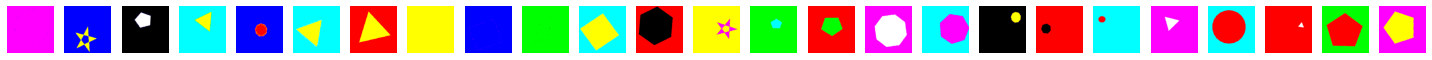

[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]]


In [9]:
plotImages(imgs)
print(labels)

In [12]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

2022-03-18 23:57:59.731210: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.
2022-03-18 23:58:00.174531: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.
2022-03-18 23:58:00.335251: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.
2022-03-18 23:58:02.847731: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.


In [13]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [25]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [26]:
for layer in model.layers:
    layer.trainable = False

In [27]:
model.add(Dense(units=len(shapes_list), activation='softmax'))

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [29]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
history = model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=7,
    verbose=1
)

Epoch 1/7
648/648 [==============================] - 5734s 9s/step - loss: 0.9837 - accuracy: 0.6349 - val_loss: 0.7607 - val_accuracy: 0.7189
Epoch 2/7
648/648 [==============================] - 5736s 9s/step - loss: 0.6274 - accuracy: 0.7642 - val_loss: 0.6418 - val_accuracy: 0.7417
Epoch 3/7
648/648 [==============================] - 6370s 10s/step - loss: 0.5382 - accuracy: 0.8008 - val_loss: 0.5757 - val_accuracy: 0.7672
Epoch 4/7
648/648 [==============================] - 6638s 10s/step - loss: 0.4845 - accuracy: 0.8246 - val_loss: 0.5403 - val_accuracy: 0.7889
Epoch 5/7
648/648 [==============================] - 6270s 10s/step - loss: 0.4463 - accuracy: 0.8399 - val_loss: 0.5426 - val_accuracy: 0.7961
Epoch 6/7
648/648 [==============================] - 6054s 9s/step - loss: 0.4174 - accuracy: 0.8527 - val_loss: 0.5107 - val_accuracy: 0.7828
Epoch 7/7
648/648 [==============================] - 6194s 10s/step - loss: 0.3929 - accuracy: 0.8618 - val_loss: 0.4829 - val_accuracy: 0.

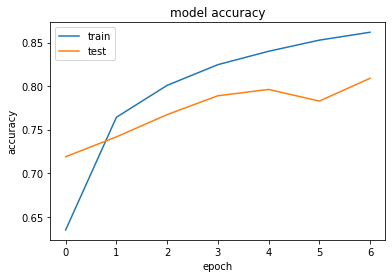

In [31]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

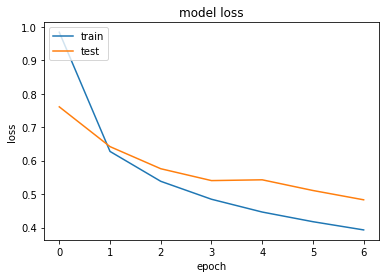

In [32]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [33]:
test_imgs, test_labels = next(test_batches)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

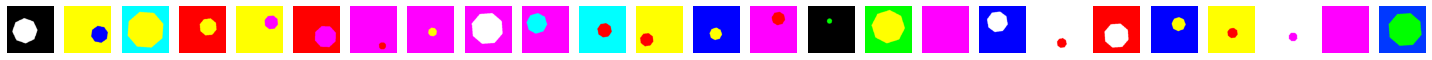

[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [34]:
plotImages(test_imgs)
print(test_labels)

In [35]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=1)

72/72 [==============================] - 644s 9s/step


In [36]:
np.round(predictions)

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [37]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 98   0  64   1   3   0  28   0   6]
 [  0 197   0   2   0   1   0   0   0]
 [ 28   0 158   0   0   0   1   0  13]
 [  0   1   0 197   0   1   0   1   0]
 [ 10   0   3   2 116   1  45  23   0]
 [  0   0   0   1   0 194   0   5   0]
 [ 51   0  10   0  15   0 121   1   2]
 [  1   0   0   2  23  13   1 160   0]
 [  1   0  11   0   0   0   0   0 188]]


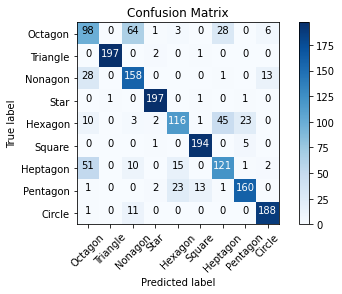

In [39]:
cm_plot_labels = shapes_list
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [41]:
print(model.evaluate(x=test_batches, steps=len(test_batches), verbose=1))
# returns loss and the accuracy

72/72 [==============================] - 624s 9s/step - loss: 0.4853 - accuracy: 0.7939
[0.48529407382011414, 0.7938888669013977]


In [42]:
# saving the model
model.save('saved_premodel.h5')